# Исследование E-Commerce Data

### Задача: выявить, где упущена выручка

Обработка данных

In [290]:
import pandas as pd
import numpy as np

dataset = pd.read_csv(r'/Users/allastepannikova/Downloads/data 2.csv',encoding='cp1251', dtype='object')
dataset['InvoiceDate'] = pd.to_datetime(dataset['InvoiceDate'])
dataset['UnitPrice']=dataset['UnitPrice'].astype('float')
dataset['Quantity']=dataset['Quantity'].astype('int')
dataset

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


In [291]:
dataset[dataset['UnitPrice'] < 0] # проверка на данные, которые являются выбросными значениями 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [292]:
dataset['Country'][dataset['CustomerID'].isna()==True].value_counts() # почти 1/5 данных не имеет данных о клиенте, что довольно существенная часть
#причем большинство из united kingdom (как и для всех данных превалирующая страна - Англия). 
# для расчета метрики retention rate было принято решение посчитать без этой неизвестной части

Country
United Kingdom    133600
EIRE                 711
Hong Kong            288
Unspecified          202
Switzerland          125
France                66
Israel                47
Portugal              39
Bahrain                2
Name: count, dtype: int64

In [293]:
dataset_without_nonames = dataset[dataset['CustomerID'].isna()==False]
dataset_without_nonames.describe() #при этом цена не отрицательна (минимальное выше 0)

,Quantity,InvoiceDate,UnitPrice
count,406829.000000,406829,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207424,3.460471
min,-80995.000000,2010-12-01 08:26:00,0.000000
25%,2.000000,2011-04-06 15:02:00,1.250000
50%,5.000000,2011-07-31 11:48:00,1.950000
75%,12.000000,2011-10-20 13:06:00,3.750000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,248.693370,NaN,69.315162


In [294]:
dataset_without_nonames[dataset_without_nonames['Quantity'] < 0] # в данных лежат не только транзакции покупки, но и транзакции возвратов

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


In [295]:
current_data = dataset_without_nonames.sort_values(by=['CustomerID','InvoiceDate'])[['CustomerID','InvoiceDate']]
current_data['InvoiceDay'] = current_data['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m-%d'))
current_data= current_data.drop(['InvoiceDate'], axis=1)
quant_per_date=[]
cod =current_data['CustomerID'].iloc[0]
date = current_data['InvoiceDay'].iloc[0]
quant_per_date.append(1)

for i in range(1, current_data.shape[0]):
    if (current_data['CustomerID'].iloc[i]==cod):
        quant_per_date.append(0)
    else:
        cod =current_data['CustomerID'].iloc[i]
        date = current_data['InvoiceDay'].iloc[i]
        quant_per_date.append(1)
current_data['New']=quant_per_date 

In [296]:
current_data= current_data.drop(['CustomerID'], axis=1)

result=pd.merge(current_data, dataset_without_nonames, left_index=True, right_index=True)
result = result.sort_values(by=['InvoiceDate','CustomerID'])
result['Revenue'] = result['UnitPrice']*result['Quantity']
result

,InvoiceDay,New,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,2010-12-01,1,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,2010-12-01,0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,2010-12-01,0,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,2010-12-01,0,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,2010-12-01,0,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...,...,...
541904,2011-12-09,0,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,2011-12-09,0,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,2011-12-09,0,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,2011-12-09,0,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [297]:
curr = result[result['Quantity']>0][['InvoiceDate','CustomerID','New']] 
#если мы не убираем отрицательное количество (возвраты) - они учитываются как приход нового клиента в первый месяц
#curr = result[['InvoiceDate','CustomerID','New']] 
curr['Month'] = curr['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m'))
curr=curr.drop(['InvoiceDate'], axis=1)
sum_table = curr.groupby(['Month','CustomerID']).sum()
list_clients_more_one = []
for el in range(sum_table.shape[0]):
    if sum_table['New'].iloc[el] == 0:
        list_clients_more_one.append(1)
    else:
        list_clients_more_one.append(0)
sum_table['Two_more_transact'] = list_clients_more_one
sum_table

New  Two_more_transact
Month   CustomerID                        
2010-12 12347         1                  0
        12348         1                  0
        12370         1                  0
        12377         1                  0
        12383         1                  0
...                 ...                ...
2011-12 18245         0                  1
        18272         0                  1
        18273         0                  1
        18282         0                  1
        18283         0                  1

[13055 rows x 2 columns]

In [298]:
#создание сводной таблицы по счету новых и лояльных клиентов
sum_table=sum_table.reset_index()
sum_table= sum_table.drop(['CustomerID'], axis=1)
table_for_graphic = sum_table.groupby(['Month']).sum() 
RR = [0]
for el in range(1, table_for_graphic.shape[0]):
    RR.append(round(table_for_graphic['Two_more_transact'].iloc[el]/(table_for_graphic['Two_more_transact'].iloc[el-1]+table_for_graphic['New'].iloc[el-1])*100,2))

table_for_graphic['Retention Rate, %'] = RR
table_for_graphic
#48 нулей в первый месяц - ИЗВЕСТНЫЕ ПО КОДУ клиенты, возвращали что-то в стартовый месяц в датасете
#возможно они могли купить под None ID, а вернуть под известным ID. (мы убрали None-ID строки)

,New,Two_more_transact,"Retention Rate, %"
Month,,,
2010-12,837,48,0.00
2011-01,394,347,39.21
2011-02,365,393,53.04
2011-03,435,539,71.11
2011-04,293,563,57.80
2011-05,278,778,90.89
2011-06,234,757,71.69
2011-07,184,765,77.19
2011-08,167,768,80.93


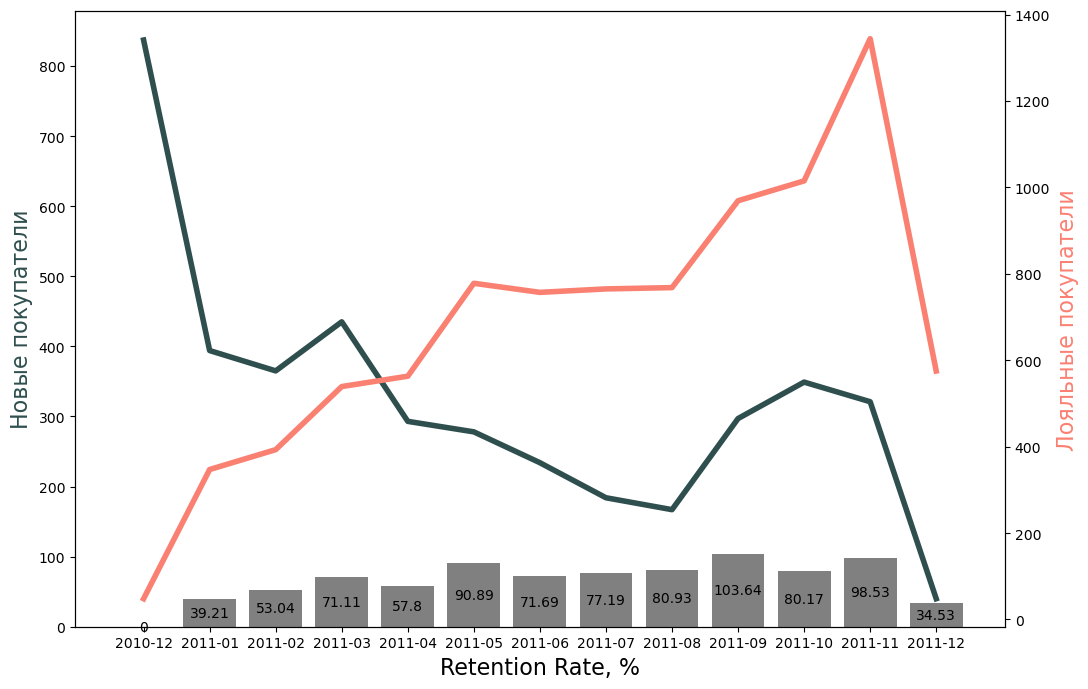

In [299]:
import matplotlib.pyplot as plt
col1 = 'darkslategray'
col2 = 'salmon'
col3= 'grey'

fig,ax = plt.subplots(figsize=(12, 8))
ax.plot(table_for_graphic.index, table_for_graphic['New'], linewidth=4, color=col1)
ax.set_xlabel('Retention Rate, %', fontsize=16)
ax.set_ylabel('Новые покупатели', color=col1, fontsize= 16)
ax2 = ax.twinx()
ax2.plot(table_for_graphic.index, table_for_graphic['Two_more_transact'], linewidth=4 ,color=col2)
ax2.set_ylabel('Лояльные покупатели', color=col2, fontsize=16)
rr = ax.bar(table_for_graphic.index, table_for_graphic['Retention Rate, %'], color=col3)
exit = ax.bar_label(rr, label_type='center')

График отражает общую тенденцию прихода и возврата покупателей платформы (не учитывая безымянных клиентов и возвраты). Метрика retention в процентном соотношении кажется весьма удачной с апреля 2011 года. Однако, заметно, что декабрь 2011 неудачный в плане продаж - месяц не полный. Проверим:

In [300]:
dataset['InvoiceDate'].max() # даже половину месяца не охватили. значит, показатели по декабрю нерепрезентативны.

Timestamp('2011-12-09 12:50:00')

В целом, динамика отличная и виден рост лояльности клиентов (количество возвращающихся клиентов растет).А вот приходящие клиенты непостоянно увеличиваются в количестве. Данные по декабрю 2010 тоже сложно оценить - это только начало доступного по данным периода. А вот с января 2011 по ноябрь 2011 статистика отражает общую картину поведения покупателей.

Посмотрим, что лежит в возвратах:

In [301]:
new_current_dataset = dataset[dataset['Quantity']<0][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
new_current_dataset['Revenue_lost'] = new_current_dataset['Quantity']*new_current_dataset['UnitPrice']*(-1)
new_current_dataset = new_current_dataset.sort_values(by=['Revenue_lost'], ascending=False)
new_current_dataset

,CustomerID,Quantity,StockCode,Description,UnitPrice,Revenue_lost
540422,16446,-80995,23843,"PAPER CRAFT , LITTLE BIRDIE",2.08,168469.60
61624,12346,-74215,23166,MEDIUM CERAMIC TOP STORAGE JAR,1.04,77183.60
222681,15098,-1,M,Manual,38970.00,38970.00
524602,NaN,-1,AMAZONFEE,AMAZON FEE,17836.46,17836.46
43702,NaN,-1,AMAZONFEE,AMAZON FEE,16888.02,16888.02
...,...,...,...,...,...,...
338957,NaN,-22,22823,test,0.00,0.00
150148,NaN,-28,84251J,NaN,0.00,0.00
415583,NaN,-200,23343,20713 wrongly marked,0.00,0.00
340681,NaN,-4,16207B,NaN,0.00,0.00


<Axes: title={'center': 'The lost revenue pie'}, ylabel='Revenue_lost'>

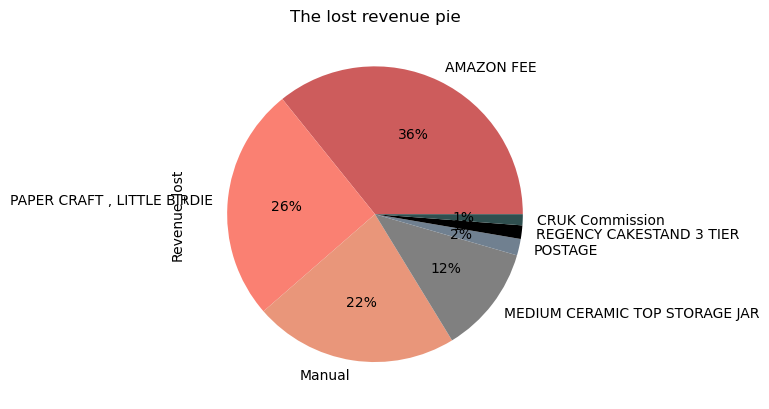

In [302]:
new_for_pie = new_current_dataset[['Description', 'Revenue_lost']]
new_for_pie = new_for_pie.groupby(['Description']).sum()
new_for_pie = new_for_pie.sort_values(by=['Revenue_lost'], ascending=False)
new_for_pie = new_for_pie.head(7)

new_for_pie.plot(kind='pie', y='Revenue_lost', autopct='%1.0f%%',
colors = ['indianred','salmon','darksalmon','grey','slategray','black','darkslategray'],
                                                legend=False,
                                                title='The lost revenue pie')

Самые дорогие по совокупной упущенной выручке возвращаемые товары - paper craft, lttle birdie и medium ceramic top storage jar. Остальные отображены на круговой диаграмме. Необходимо понять, почему их возвращают (ненадлежащее передвижение и брак?) Возвраты postage и manual - тоже что-то сомнительное.

Amazon fee - оплата за продажу на амазон. И это большая часть упущенной выручки.

Посмотрим долю возвратов в выручке (действительная конверсия в валовую выручку):

In [303]:
new_current_for_revenue = dataset[['InvoiceDate','CustomerID','Quantity','StockCode','Description','UnitPrice']]
new_current_for_revenue['Revenue'] = new_current_for_revenue['Quantity']*new_current_for_revenue['UnitPrice']
new_current_for_revenue['InvoiceMonth'] = new_current_for_revenue['InvoiceDate'].apply(lambda x : x.strftime('%Y-%m'))
new_current_for_revenue

/var/folders/d9/bfhvjqps6xdds9gmhtflh16c0000gn/T/ipykernel_1387/2546412351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_current_for_revenue['Revenue'] = new_current_for_revenue['Quantity']*new_current_for_revenue['UnitPrice']


,InvoiceDate,CustomerID,Quantity,StockCode,Description,UnitPrice,Revenue,InvoiceMonth
0,2010-12-01 08:26:00,17850,6,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,15.30,2010-12
1,2010-12-01 08:26:00,17850,6,71053,WHITE METAL LANTERN,3.39,20.34,2010-12
2,2010-12-01 08:26:00,17850,8,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,22.00,2010-12
3,2010-12-01 08:26:00,17850,6,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,20.34,2010-12
4,2010-12-01 08:26:00,17850,6,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,20.34,2010-12
...,...,...,...,...,...,...,...,...
541904,2011-12-09 12:50:00,12680,12,22613,PACK OF 20 SPACEBOY NAPKINS,0.85,10.20,2011-12
541905,2011-12-09 12:50:00,12680,6,22899,CHILDREN'S APRON DOLLY GIRL,2.10,12.60,2011-12
541906,2011-12-09 12:50:00,12680,4,23254,CHILDRENS CUTLERY DOLLY GIRL,4.15,16.60,2011-12
541907,2011-12-09 12:50:00,12680,4,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.15,16.60,2011-12


In [304]:
new_current_for_revenue_2 = dataset[dataset['Quantity']>0][['InvoiceDate','CustomerID','Quantity','StockCode','Description','UnitPrice']]
new_current_for_revenue_2['Revenue'] = new_current_for_revenue_2['Quantity']*new_current_for_revenue_2['UnitPrice']
new_current_for_revenue_2['InvoiceMonth'] = new_current_for_revenue_2['InvoiceDate'].apply(lambda x : x.strftime('%Y-%m'))
new_current_for_revenue_2

,InvoiceDate,CustomerID,Quantity,StockCode,Description,UnitPrice,Revenue,InvoiceMonth
0,2010-12-01 08:26:00,17850,6,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,15.30,2010-12
1,2010-12-01 08:26:00,17850,6,71053,WHITE METAL LANTERN,3.39,20.34,2010-12
2,2010-12-01 08:26:00,17850,8,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,22.00,2010-12
3,2010-12-01 08:26:00,17850,6,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,20.34,2010-12
4,2010-12-01 08:26:00,17850,6,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,20.34,2010-12
...,...,...,...,...,...,...,...,...
541904,2011-12-09 12:50:00,12680,12,22613,PACK OF 20 SPACEBOY NAPKINS,0.85,10.20,2011-12
541905,2011-12-09 12:50:00,12680,6,22899,CHILDREN'S APRON DOLLY GIRL,2.10,12.60,2011-12
541906,2011-12-09 12:50:00,12680,4,23254,CHILDRENS CUTLERY DOLLY GIRL,4.15,16.60,2011-12
541907,2011-12-09 12:50:00,12680,4,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.15,16.60,2011-12


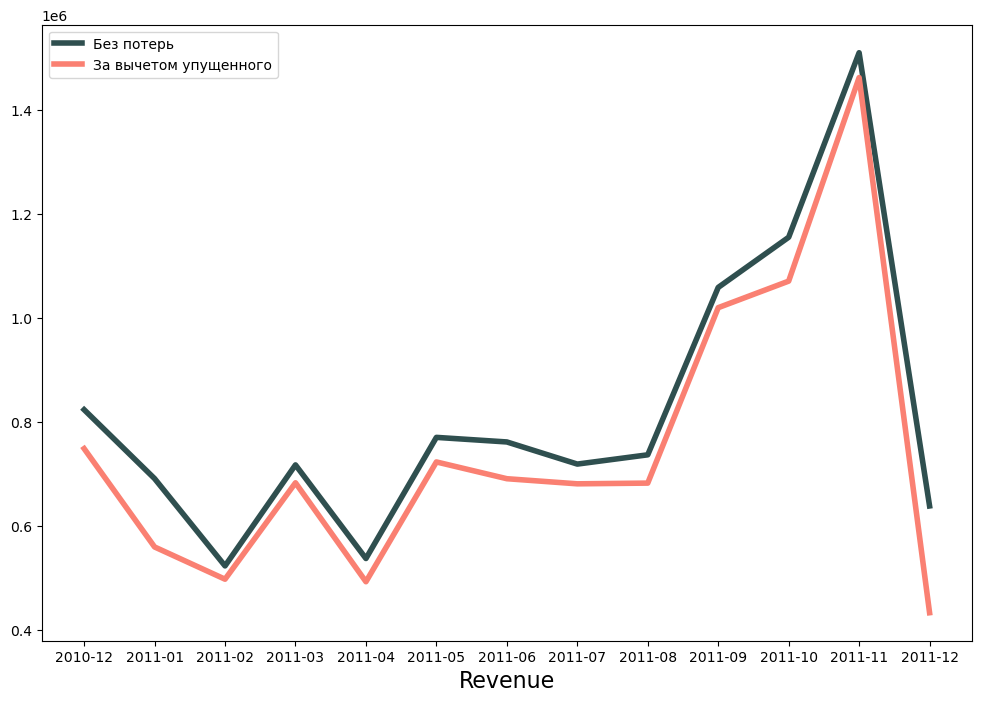

In [305]:
svod_2 = new_current_for_revenue_2[['InvoiceMonth','Revenue']]
svod_2 = svod_2.groupby(['InvoiceMonth']).sum()
svod_1=new_current_for_revenue[['InvoiceMonth','Revenue']]
svod_1 = svod_1.groupby(['InvoiceMonth']).sum()

col1 = 'darkslategray'
col2 = 'salmon'

fig,ax = plt.subplots(figsize=(12, 8))
ax1 = ax.plot(svod_2.index, svod_2['Revenue'], linewidth=4, color=col1, label='Без потерь')
ax.set_xlabel('Revenue', fontsize=16)
ax2=ax.plot(svod_1.index, svod_1['Revenue'], linewidth=4 ,color=col2, label='За вычетом упущенного')
ax.legend(['Без потерь','За вычетом упущенного'])

Сначала года упущено было не мало денег (видно по графику), но судя по последним месяцам стало лучше, вероятно, отладили процесс с браком и остались только Amazon Fee.

Теперь глянем самых "кормящих" клиентов:

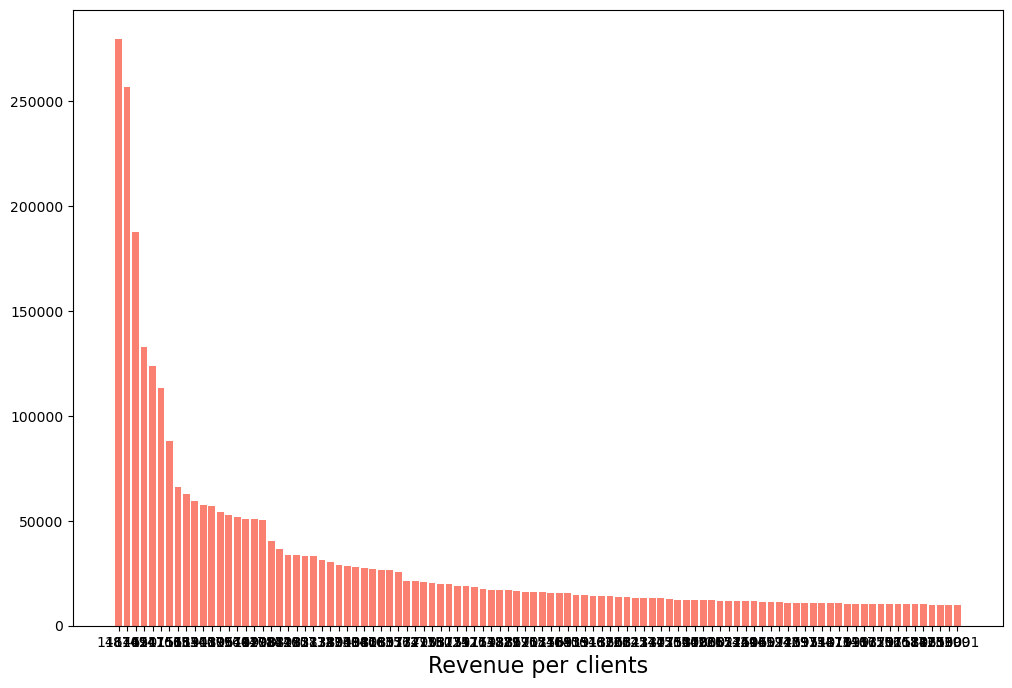

In [306]:
svod_clients=new_current_for_revenue[['CustomerID','Revenue']]
svod_clients=svod_clients.groupby(['CustomerID']).sum()
svod_clients=svod_clients.sort_values(by=['Revenue'], ascending=False)
svod_clients=svod_clients.head(100)

col2 = 'salmon'

fig,ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel('Revenue per clients', fontsize=16)
rr = ax.bar(svod_clients.index, svod_clients['Revenue'], color=col2)
#эх, если бы можно было смерджить со справочником названий компаний по ID, я бы это сделала. но пока только номера

График специально вмещает первые 100 клиентов по выручке - заметен разрыв в суммах для самых крупных. То есть, можно разобраться как и почему они столько покупают через CustDev с ними, выделить свою ЦА и более точечно направить маркетинговые стратегии, чтобы развить остальных клиентов (заставить их покупать больше, сравни с крупными рыбами).


### В ходе микро-исследования хотелось найти следующие точки роста: 
    1. Клиентский опыт (привлекательность, лояльность);
    2. Денежную отдачу клиентов - упущенные возможности, прощупывание своей ЦА через самых крупных и лояльных покупателей;
Благодаря исследованию, выявлены атрибуты для дальнейшего действия по увеличению выручки.